# Import necessary packages

In [1]:
#import modules and pytorch libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers import Dropout
print(tf.__version__)
tf.config.set_visible_devices([], 'GPU')

# reproducibility
random.seed(147)
np.random.seed(147)
torch.manual_seed(147)
tf.random.set_seed(147)

2.11.0


In [2]:
# run this cell if your jupyter notebook kernel has died
#import os
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Import all images and split for training, validation, and testing

In [3]:
#importing training and test dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (if needed)
    transforms.Resize((256, 256)),  # Resize the image to (256, 256) pixels
    transforms.ToTensor()  # Convert to a tensor
])

# Load the images from the two folders
# firstly create new folder named 'data' containing yes_output and no_output files
image_set = ImageFolder(root='Br35H/data', transform=transform)

# Define the ratio for each set
train_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation
test_ratio = 0.1   # 10% for testing

# Calculate the lengths of each set
train_len = int(len(image_set) * train_ratio)
val_len = int(len(image_set) * val_ratio)
test_len = len(image_set) - train_len - val_len

# Split the dataset using random_split
train_set, val_set, test_set = random_split(image_set, [train_len, val_len, test_len])

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

# Here I chose to work with tensorflow model for its convenience
## Define a converter here so pytorch dataloader can work with tensorflow

In [22]:
# pytorch to tensorflow converter, so that data can be read by tf model
def convert_to_numpy(loader):
    data = []
    labels = []
    for batch in loader:
        images, batch_labels = batch
        data.append(images.numpy())
        labels.append(batch_labels.numpy())
    data = np.concatenate(data, axis=0)
    labels = np.concatenate(labels, axis=0)
    # Reshape the data to (batch_size, height, width, channels)
    data = data.reshape(-1, 256, 256, 1)
    return data, labels

x_train, y_train = convert_to_numpy(train_loader)
x_val, y_val = convert_to_numpy(val_loader)
x_test, y_test = convert_to_numpy(test_loader)

# Display few images in the folder with corresponding labels
## 0: absence of brain tumour, 1: brain tumour positive

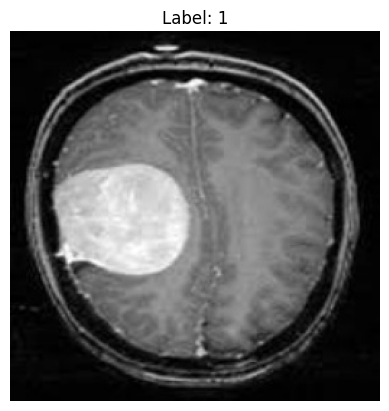

Image_No: 2479


In [5]:
# Here I display one random image from image_set to check
number = random.randint(0, 2999)
image, label = image_set[number]
image = np.transpose(image, (1, 2, 0))

# Display the image in grayscale
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()
print(f"Image_No: {number}")

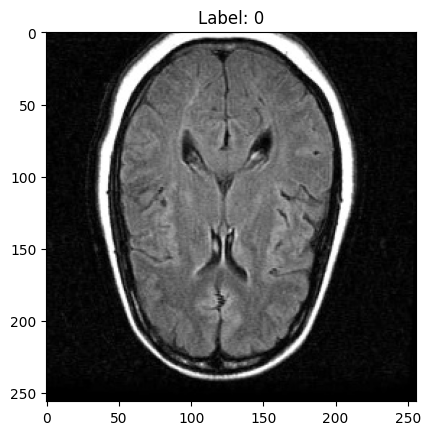

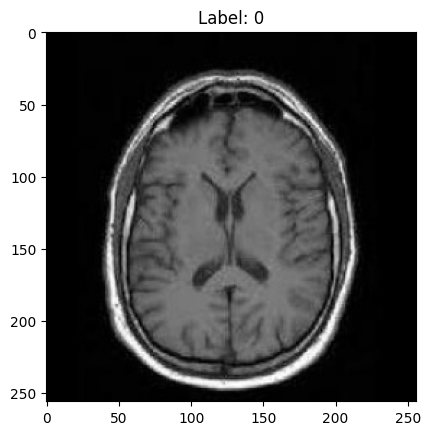

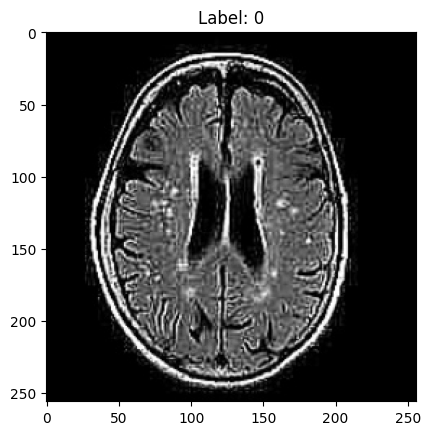

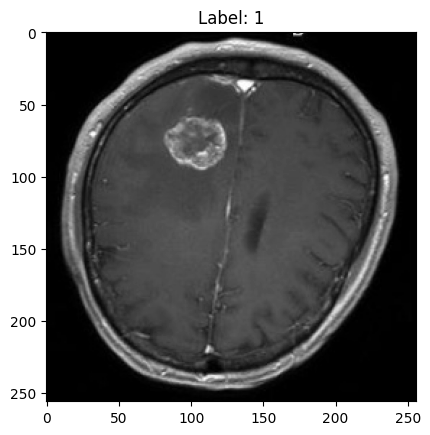

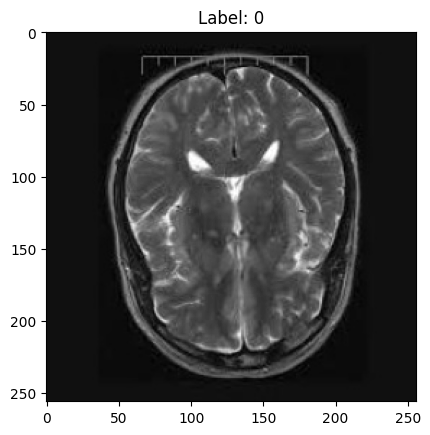

In [6]:
# Display 5 random images from train_loader in original form
# To confirm we have successfully loaded images ready for training
def unnormalize(img):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))  # transpose the dimensions
    return img

images, labels = next(iter(train_loader))

# Visualize the first 5 images and their labels
for i in range(5):
    plt.imshow(unnormalize(images[i]), cmap='gray')
    plt.title('Label: {}'.format(labels[i]))
    plt.show()

# Define CNN model architecture and compile it

In [7]:
#define neural network class (CNN model architecture)
model = Sequential([

# Convolutional layer 1
    Conv2D(32, (3, 3), padding='same', activation = 'relu', input_shape=(256, 256, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

# Convolutional layer 2
    Conv2D(32, (3, 3), padding='same', activation = 'relu', kernel_initializer = 'he_uniform'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),

# Dense layer 1
    Dense(512, activation='relu'),
    Dropout(0.5),

# Dense layer 3 (output)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer = 'sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     1

# Training the CNN for 14 epochs with validation

In [8]:
# training
history = model.fit(x_train, y_train, epochs = 14, batch_size= 32, validation_data=(x_val, y_val))

Epoch 1/14


2023-03-08 21:47:58.903530: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-08 21:47:59.732177: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2a4cb1ad0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-08 21:47:59.732804: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-03-08 21:48:00.143052: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 56s 742ms/step - loss: 1.7454 - accuracy: 0.7429 - val_loss: 6.3755 - val_accuracy: 0.4633
Epoch 2/14
75/75 [==============================] - 59s 780ms/step - loss: 0.3325 - accuracy: 0.8537 - val_loss: 9.5774 - val_accuracy: 0.4633
Epoch 3/14
75/75 [==============================] - 56s 741ms/step - loss: 0.2286 - accuracy: 0.9096 - val_loss: 8.2352 - val_accuracy: 0.4667
Epoch 4/14
75/75 [==============================] - 56s 742ms/step - loss: 0.1589 - accuracy: 0.9388 - val_loss: 5.2262 - val_accuracy: 0.5033
Epoch 5/14
75/75 [==============================] - 56s 743ms/step - loss: 0.1090 - accuracy: 0.9617 - val_loss: 2.5569 - val_accuracy: 0.6167
Epoch 6/14
75/75 [==============================] - 51s 681ms/step - loss: 0.0670 - accuracy: 0.9779 - val_loss: 1.5827 - val_accuracy: 0.7200
Epoch 7/14
75/75 [==============================] - 49s 651ms/step - loss: 0.0559 - accuracy: 0.9808 - val_loss: 0.5678 - val_accuracy: 0.8767
Epoch 8/14

# Evaluate CNN on testing image data
## model displays 98.33% accuracy on unseen data

In [9]:
# evaluation on testing data
test_loss, test_acc = model.evaluate(x_test, y_test)

10/10 [==============================] - 1s 138ms/step - loss: 0.0470 - accuracy: 0.9900


# Visualise accuracy and loss values over training epochs

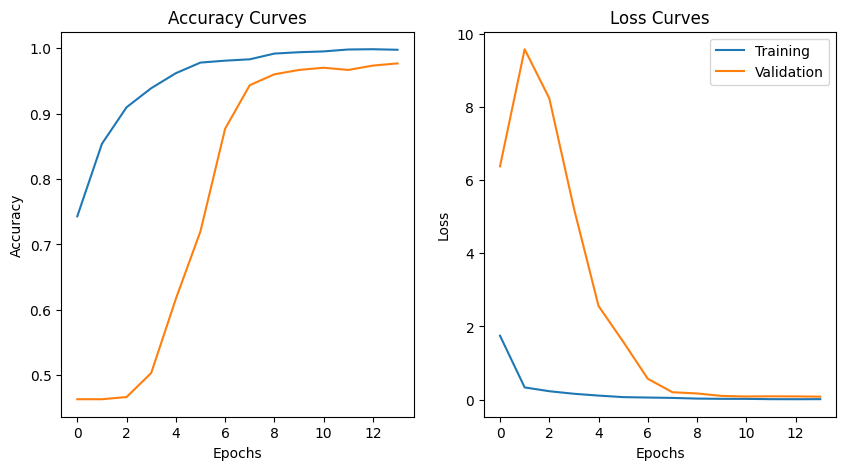

In [10]:
# plot accuracy and loss over training epochs
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy and loss curves side by side
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) # Create the left subplot
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2) # Create the right subplot
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show() # Show the plots

# Save model into HDF5 file or read the file when reopening python

In [11]:
# Save the entire model to a HDF5 file
model.save('tumour_detector.h5')

In [12]:
# OR YOU CAN LOAD THE TRAINED MODEL FOR ANALYSIS when reopen python
model = tf.keras.models.load_model('tumour_detector.h5')

# Visualise CNN decision making in some of testing images
## Y-axis values represent model confidence on each choices

1/1 [==============================] - 0s 88ms/step


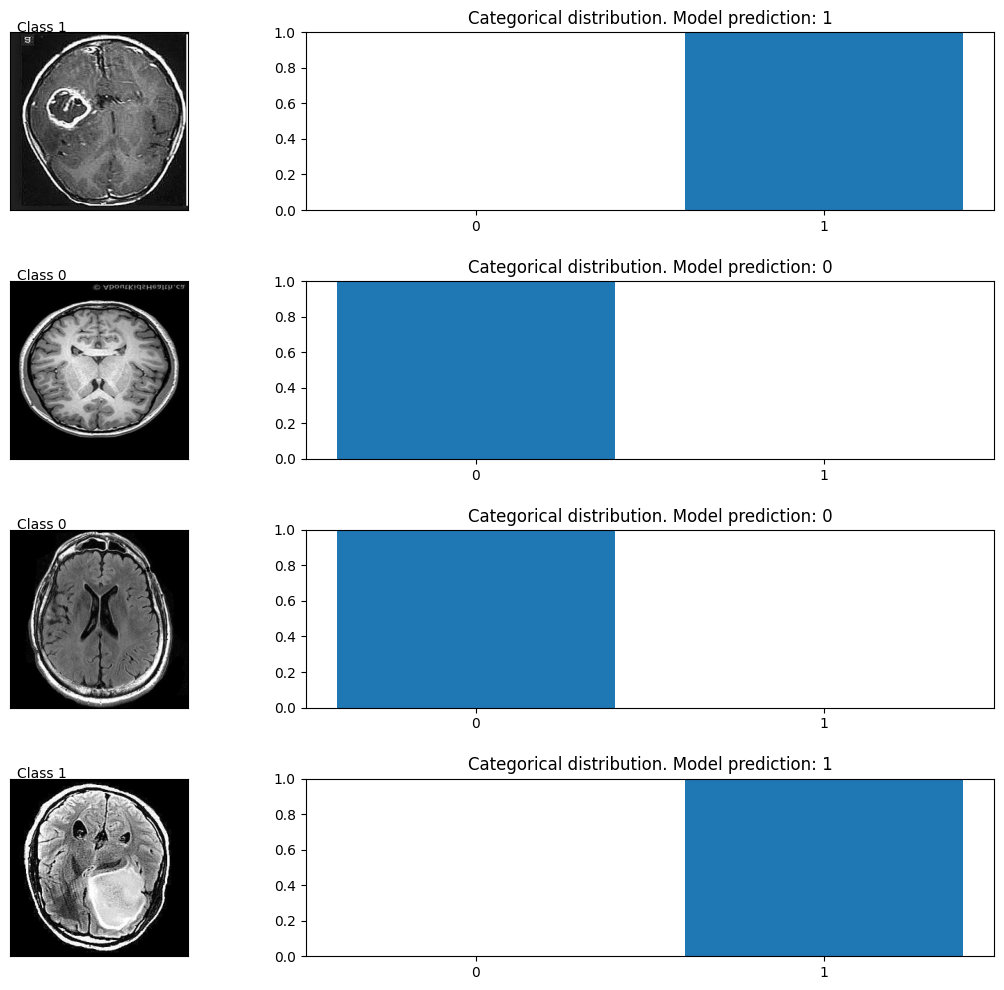

In [13]:
# visualise our model's relative confidence (decision making) on testing images
num_test_images = x_test.shape[0]

random_inx = np.random.choice(num_test_images, 4)
random_test_images = x_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)
complement = np.ones_like(predictions) - predictions
predictions = np.concatenate((complement, predictions), axis=1)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image), cmap = 'gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Class {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")

for ax in axes[:,1]:
    ax.set_ylim([0,1])

plt.show()

# Confusion matrix on testing data: 99% accuracy

10/10 [==============================] - 2s 173ms/step
Testing Accuracy = 0.990


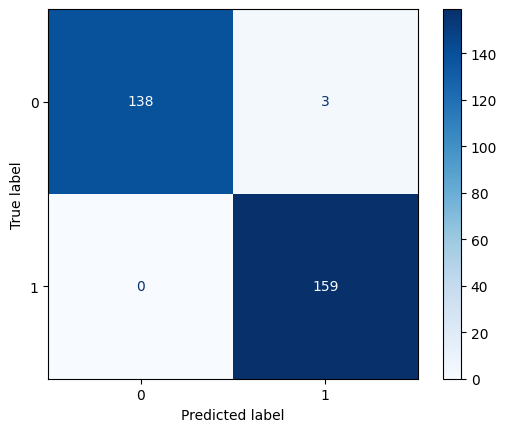

In [14]:
# Confusion matrix on testing set to get an overall picture
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(x_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Testing Accuracy = %.3f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx)
disp = disp.plot(cmap=plt.cm.Blues)

# Confusion matrix for validation data: 97.7% accuracy

10/10 [==============================] - 2s 173ms/step
Val Accuracy = 0.977


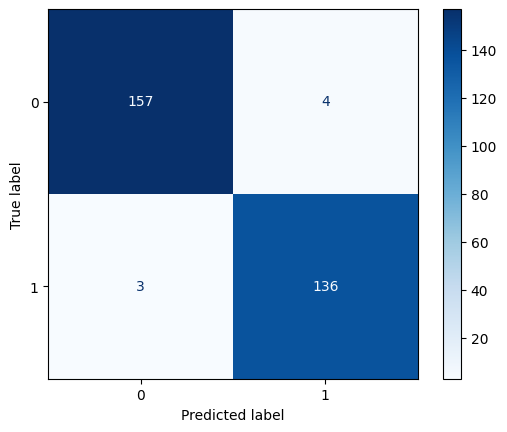

In [15]:
predictions = model.predict(x_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.3f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx)
disp = disp.plot(cmap=plt.cm.Blues)

## Define functions that read an image folder and process images inside just like before. Processed images are ready to plug into model for prediction

In [20]:
# Define a convert_to_numpy function which reads in image folders and process them
from PIL import Image
import os

def read_images(pred_path, transform):
    img_filenames = os.listdir(pred_path)
    img_width, img_height = 256, 256
    
    # Create a numpy array to store the images:
    imgs = np.zeros((len(img_filenames), img_width, img_height), dtype=np.float32)

    # Loop through the image filenames, load each image, and preprocess it:
    for i, filename in enumerate(img_filenames):
        img = Image.open(os.path.join(pred_path, filename))
        img = transform(img)
        imgs[i] = img
    
    # Reshape the data to (batch_size, height, width, channels)
    imgs = imgs.reshape(-1, img_width, img_height, 1)
    return imgs

# Get prediction images from pred_output image folder 
pred_path = 'Br35H/pred_output'
img_filenames = os.listdir(pred_path)
img_width, img_height = 256, 256
pred_imgs = read_images(pred_path, transform)

# Visualise model predictions of some images from folder 'pred_output'
## Model could make mistakes like the frirst one

1/1 [==============================] - 0s 117ms/step


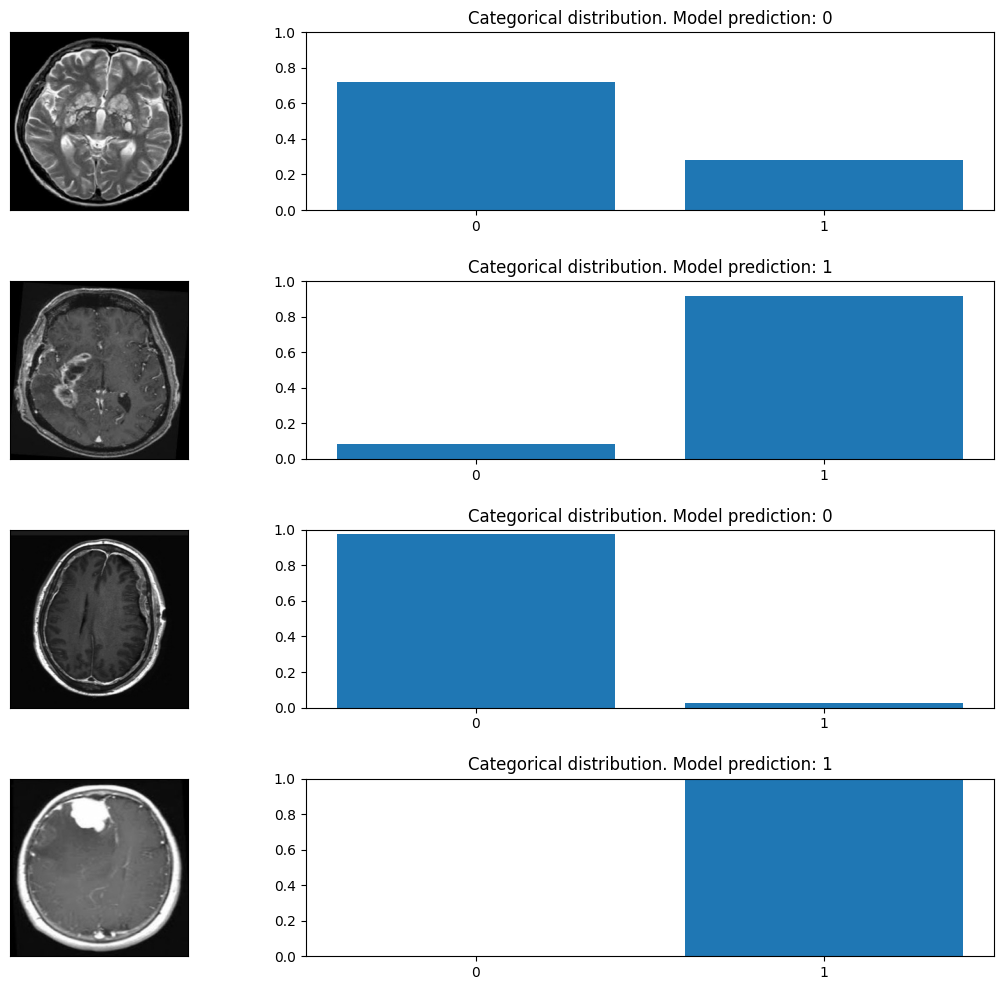

In [21]:
# visualise CNN decision making by displaying confidences
num_test_images = pred_imgs.shape[0]
random_inx = np.random.choice(num_test_images, 4)
random_test_images = pred_imgs[random_inx, ...]

predictions = model.predict(random_test_images)
complement = np.ones_like(predictions) - predictions
predictions = np.concatenate((complement, predictions), axis=1)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image) in enumerate(zip(predictions, random_test_images)):
    axes[i, 0].imshow(np.squeeze(image), cmap = 'gray')
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")

for ax in axes[:,1]:
    ax.set_ylim([0,1])
    
plt.show()

# Read in whole dataset with 3000 images and assess accuracy

In [24]:
testing_set = ImageFolder(root='Br35H/Testing', transform=transform)

batch_size = 32
testing = torch.utils.data.DataLoader(testing_set, batch_size=batch_size)

x_testing, y_testing = convert_to_numpy(testing)
len(y_testing)

3000

In [25]:
test_loss, test_acc = model.evaluate(x_testing, y_testing)

94/94 [==============================] - 14s 141ms/step - loss: 0.0287 - accuracy: 0.9913


94/94 [==============================] - 14s 144ms/step
Testing Accuracy = 0.991


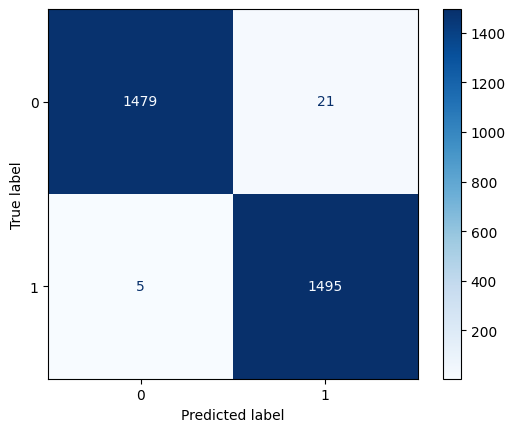

In [26]:
predictions = model.predict(x_testing)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_testing, predictions)
print('Testing Accuracy = %.3f' % accuracy)

confusion_mtx = confusion_matrix(y_testing, predictions) 
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx)
disp = disp.plot(cmap=plt.cm.Blues)